In [1]:
!pip install pennylane torch torchvision matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93

In [2]:
import pennylane as qml
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aminelaatam/weed-classification")

print("Path to dataset files:", path)

100%|██████████| 378M/378M [00:07<00:00, 54.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aminelaatam/weed-classification/versions/2


In [4]:
# Set the number of qubits based on the dataset's features (5-12 is ideal for Amplitude Encoding)
NUM_QUBITS = 5  # Adjust based on feature vector size


In [5]:
# Quantum Device (Simulated Backend)
dev = qml.device("default.qubit", wires=NUM_QUBITS)

In [6]:
# Quantum Circuit (Variational Quantum Circuit - VQC)
def circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(NUM_QUBITS))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(NUM_QUBITS))
    return qml.expval(qml.PauliZ(0))  # Measurement

In [7]:
# Add this import statement at the beginning of your file or cell:
import pennylane as qml

# Quantum Node
QNN = qml.QNode(circuit, dev, interface="torch")

In [8]:
# Define a Torch Quantum Layer
class QuantumLayer(nn.Module):
    def __init__(self, num_qubits, num_layers):
        super().__init__()
        weight_shapes = {"weights": (num_layers, num_qubits, 3)}
        self.q_layer = qml.qnn.TorchLayer(QNN, weight_shapes)

    def forward(self, x):
        return self.q_layer(x)


In [9]:
# # Full Quantum Neural Network
# class QuantumNeuralNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.qnn = QuantumLayer(NUM_QUBITS, 2)  # 2-layer QNN
#         self.fc = nn.Linear(1, 2)  # Output layer for classification

#     def forward(self, x):
#         x = self.qnn(x)
#         return self.fc(x)


In [10]:
# # Full Quantum Neural Network
# class QuantumNeuralNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(1024, NUM_QUBITS) # Added a classical layer to reduce dimensionality
#         self.qnn = QuantumLayer(NUM_QUBITS, 2)  # 2-layer QNN
#         self.fc2 = nn.Linear(1, 2)  # Output layer for classification

#     def forward(self, x):
#         x = self.fc1(x) # Pass through the classical layer to reduce dimensionality
#         x = self.qnn(x)
#         # Reshape x to have dimensions (batch_size, 1) to pass through linear classifier
#         x = x.reshape(x.shape[0], 1)
#         return self.fc2(x)

In [11]:
class QuantumNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1024, NUM_QUBITS)
        self.qnn = QuantumLayer(NUM_QUBITS, 4)  # Increased layers to 4
        self.fc2 = nn.Linear(1, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.qnn(x)
        x = x.reshape(x.shape[0], 1)
        x = self.fc2(x)
        return torch.softmax(x, dim=1)

In [12]:
# Image Dataset Processing
class CornWeedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for label, category in enumerate(["corn", "weed"]):
            category_dir = os.path.join(root_dir, category)
            for img_name in os.listdir(category_dir):
                self.images.append(os.path.join(category_dir, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("L").resize((32, 32))
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]


In [13]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale images
])

In [14]:
# Load datasets
train_dataset = CornWeedDataset("/root/.cache/kagglehub/datasets/aminelaatam/weed-classification/versions/2/CornWeed/train", transform=transform) # Use the 'transform' variable here
test_dataset = CornWeedDataset("/root/.cache/kagglehub/datasets/aminelaatam/weed-classification/versions/2/CornWeed/test", transform=transform) # Use the 'transform' variable here

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [15]:
# Model, Loss, Optimizer
model = QuantumNeuralNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Quantum-aware optimizer

In [16]:
# Training Loop
def train_model(model, train_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.view(images.size(0), -1), labels
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, torch.tensor(labels))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

In [17]:
# Evaluate Model
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.view(images.size(0), -1), labels
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [18]:
# Run Training & Evaluation
train_model(model, train_loader, epochs=10)
evaluate_model(model, test_loader)


<ipython-input-16-3983548a4c60>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(outputs, torch.tensor(labels))


Epoch 1, Loss: 0.6895
Epoch 2, Loss: 0.6709
Epoch 3, Loss: 0.6646
Epoch 4, Loss: 0.6711
Epoch 5, Loss: 0.6677
Epoch 6, Loss: 0.6688
Epoch 7, Loss: 0.6674
Epoch 8, Loss: 0.6702
Epoch 9, Loss: 0.6703
Epoch 10, Loss: 0.6675
Test Accuracy: 75.65%


In [19]:
!pip install scikit-learn

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Evaluate Model
def evaluate_model(model, test_loader):
    model.eval()
    all_predicted = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.view(images.size(0), -1), labels
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predicted)
    precision = precision_score(all_labels, all_predicted)
    recall = recall_score(all_labels, all_predicted)
    f1 = f1_score(all_labels, all_predicted)
    cm = confusion_matrix(all_labels, all_predicted)

    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Corn", "Weed"], yticklabels=["Corn", "Weed"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Test Accuracy: 75.65%
Precision: 0.4571
Recall: 0.0825
F1-score: 0.1397


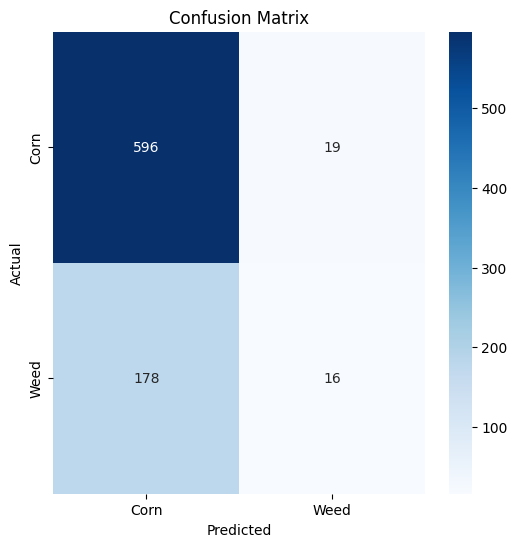

In [22]:
evaluate_model(model, test_loader)